In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

import keras # broken for keras >= 2.0, use 1.2.2
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape


Using TensorFlow backend.


## Build the Tiny-YOLO model ##

In [2]:
keras.backend.set_image_dim_ordering('th')
print("Keras backend: {}".format(keras.backend.backend()))
print("Keras image_dim_ordering: {}".format(keras.backend.image_dim_ordering()))

Keras backend: tensorflow
Keras image_dim_ordering: th


### Download YOLO Pre-trained Weight File
Download the weight file from https://pjreddie.com/darknet/yolo/  and save it to the project directory as 'yolo-tiny.weights'
    

In [3]:
from model import TinyYOLO
yolo = TinyYOLO('./yolo-tiny.weights')
model = yolo.model
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 16, 448, 448)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_1[0][0]                
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  4640        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

visualize the box on the original image

### Apply the Model on Test Images

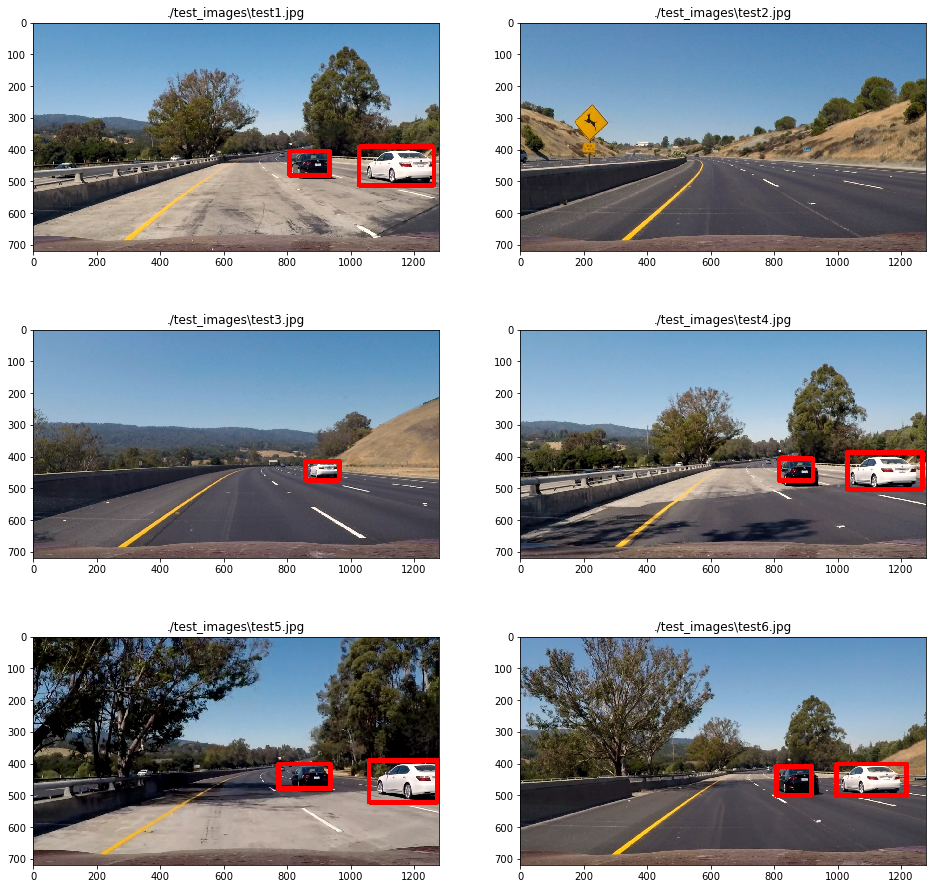

In [4]:
test_images = list(map(lambda image_file_name: (image_file_name, plt.imread(image_file_name)), 
                      glob.glob('./test_images/*.jpg')))

batch = np.array([np.transpose(cv2.resize(image[300:650,500:,:],(448,448)),(2,0,1)) 
                  for (image_path, image) in test_images])

batch = 2*(batch/255.) - 1
out = model.predict(batch)
f,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(16,16))
for i,ax in zip(range(len(batch)),[ax1,ax2,ax3,ax4,ax5,ax6]):
    boxes = yolo.get_detected_boxes(out[i], threshold = 0.18) #interpolate the vector out from the neural network, generate the boxes
    ax.imshow(yolo.draw_box(boxes,test_images[i][1],[[500,1280],[300,650]])) #visualize the box on the original image
    ax.set_title(test_images[i][0])  

## Apply the Model to Video ##

In [5]:
def frame_func(image):
    crop = image[300:650,500:,:]
    resized = cv2.resize(crop,(448,448))
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = 2*(batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    out = model.predict(batch)
    boxes = yolo.get_detected_boxes(out[0], threshold = 0.18)
    return yolo.draw_box(boxes,image,[[500,1280],[300,650]])

In [6]:
project_video_output = './project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")


In [7]:
lane_clip = clip1.fl_image(frame_func) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:14<00:00,  9.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

Wall time: 2min 15s
